
*Note:* You can run this from your computer (Jupyter or terminal), or use one of the
hosted options:

[![binder-logo](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Fspec-api-python%252FREADME.ipynb%26branch%3Dmaster)

[![deepnote-logo](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?template=deepnote&url=https://github.com/ploomber/projects/blob/master/spec-api-python/README.ipynb)


# Your first Python pipeline

This guide shows you how to run your first Ploomber pipeline.

**Note:** This is intended for a quick and interactive experience. If you want
to learn about Ploomber's core concepts and design rationale, go to the
[the next tutorial](https://ploomber.readthedocs.io/en/stable/get-started/basic-concepts.html)

## Setup (skip if using deepnote or binder)

Get code (run in a terminal):

~~~sh
git clone https://github.com/ploomber/projects
cd projects/spec-api-python
~~~

Install dependencies:

~~~sh
# if using conda
conda env create --file environment.yaml
conda activate spec-api-python

# otherwise use pip directly
pip install -r requirements.txt
~~~

## Description

This pipeline contains 3 **tasks**, the first task `get.py` gets some data,
`clean.py` cleans it and `plot.py` generates a visualization:

In [1]:
%%sh
ls *.py

clean.py
plot.py
raw.py


These three scripts make up our pipeline (or **DAG**), which is a collection
of tasks with a pre-defined execution order.

**Note:** These tasks are Python scripts, but you can use functions, notebooks,
and even SQL scripts. The next guide explains how other types of tasks work.

Ploomber integrates with Jupyter. If you open the scripts inside the
`jupyter notebook` app, they will render as notebooks. If you're using `jupyter lab`, you need to right click -> open with -> Notebook as depicted below:

![lab-open-with-nb](https://ploomber.io/doc/lab-open-with-notebook.png)

Along with the `*.py` files, there is a `pipeline.yaml` file where we declare
which files we use as tasks:

In [2]:
%%sh
cat pipeline.yaml

tasks:
  - source: raw.py
    product:
      nb: output/raw.ipynb
      data: output/data.csv

  - source: clean.py
    product:
      nb: output/clean.ipynb
      data: output/clean.csv

  - source: plot.py
    product: output/plot.ipynb


**Note:** The `pipeline.yaml` file is optional, but it gives you more flexibility.
[Click here](https://github.com/ploomber/projects/tree/master/spec-api-directory) to see an example without a `pipeline.yaml` file.

Let's plot the pipeline:

In [3]:
%%sh
# Note: plotting doesn't work in deepnote
ploomber plot

Plot saved at: pipeline.png


100%|██████████| 3/3 [00:00<00:00, 8974.97it/s]


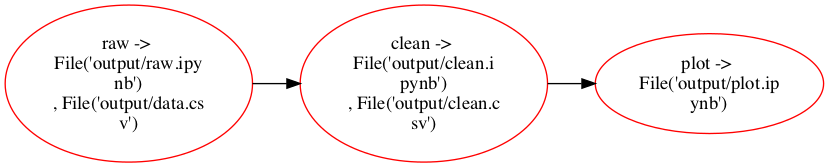

In [4]:

from IPython.display import Image
Image(filename='pipeline.png')

The `status` command gives us an overview of the pipeline:

In [5]:
%%sh
ploomber status

name    Last run      Outdated?    Product       Doc (short)    Location
------  ------------  -----------  ------------  -------------  ------------
raw     Has not been  Source code  MetaProduct(                 /Users/Edu/d
        run                        {'data': Fil                 ev/projects-
                                   e('output/da                 ploomber/spe
                                   ta.csv'),                    c-api-python
                                   'nb': File('                 /raw.py
                                   output/raw.i
                                   pynb')})
clean   Has not been  Source code  MetaProduct(                 /Users/Edu/d
        run           & Upstream   {'data': Fil                 ev/projects-
                                   e('output/cl                 ploomber/spe
                                   ean.csv'),                   c-api-python
                                   'nb': File('                 /clean

100%|██████████| 3/3 [00:00<00:00, 9439.54it/s]


## How is execution order determined?

Ploomber infers the pipeline structure from your code. If task B uses the output from
task A as input, we say A is an **upstream** dependency of B. For example, to
clean the data, we must get it first; hence, we declare the following in `clean.py`:

~~~python
# execute 'raw" task before 'clean'
upstream = ['raw']
~~~

Once we finish cleaning the data, we must save it somewhere (this is known
as a **product**). Products can be files or SQL relations. Our current example
only generates files.

To specify where to save the output of each task, we use the `product`
key. For example, the `raw` task definition looks like this:

~~~yaml
- source: raw.py
  product:
    nb: output/raw.ipynb
    data: output/data.csv
~~~

Scripts and notebooks automatically generate a copy of themselves in Jupyter
notebook format (`.ipynb`). That's why we see a notebook in the `product`
dictionary (`nb` key). The notebook format allows us to generate standalone
files with charts and tables, no need to write extra code to save our charts!

Notebooks as pipeline products are crucial concepts: `raw.py` is part of the pipeline's
source code but `output/raw.ipynb` is not. It is an artifact generated by the source code.

If you don't want to generate output notebooks, you can use a Python function
as tasks. Our upcoming tutorial goes deeper into the different types of tasks available.

## Building the pipeline

Let's build the pipeline:

In [6]:
%%sh
mkdir output
ploomber build

name    Ran?      Elapsed (s)    Percentage
------  ------  -------------  ------------
raw     True          2.91123       38.6462
clean   True          1.84655       24.5127
plot    True          2.77525       36.8411


Building task "plot": 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


This pipeline saves all the output in the `output/` directory; we have a few
data files:

In [7]:
%%sh
ls output/*.csv

output/clean.csv
output/data.csv


And a notebook for each script:

In [8]:
%%sh
ls output/*.ipynb

output/clean.ipynb
output/plot.ipynb
output/raw.ipynb


## Updating the pipeline

Quick experimentation is essential to develop a data pipeline. Ploomber allows
you to quickly run new experiments without having to keep track of tasks
dependencies.

Let's say you found a problematic column in the data and want to add more
cleaning logic to your `clean.py` script. `raw.py` does not depend
on `clean.py`, but `plot.py` does. If you modify `clean.py`, you'd have
to execute `clean.py` and then `plot.py` to bring your pipeline up-to-date.

As your pipeline grows, keeping track of task dependencies gets time-consuming.
Ploomber does that for you and only executes outdated tasks on each run.

Make some changes to the `clean.py` script, then build again:

In [9]:
%%sh
ploomber build

name    Ran?      Elapsed (s)    Percentage
------  ------  -------------  ------------
raw     False               0             0
clean   False               0             0
plot    False               0             0


0it [00:00, ?it/s]


You'll see that `raw.py` didn't run because it was not affected by the change! Try modifying any of the other tasks, then come
back and run `ploomber build`.

## Where to go from here

This tutorial showed how to build a pipeline with Ploomber; however, it only
superficially covered Ploomber's core concepts and design rationale. [the upcoming
tutorial](https://ploomber.readthedocs.io/en/stable/get-started/basic-concepts.html)
goes deeper in those terms.